In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot 

np.set_printoptions(precision=3, suppress=True)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
tf.keras.backend.set_floatx('float32')

print("Imported the modules.")

Imported the modules.


In [100]:
def Data_Prep(df,df_len,conv_tenor=True,pos_chang=True,final_df=True,add_col=True):

  if conv_tenor:

    val_mon=[]
    for i in range(df_len):
      int_val=int(df['Tenor'][i][:-1])
      if df['Tenor'][i][-1]=="M":
        val_mon.append(str(int_val*1))
      elif df['Tenor'][i][-1]=="Y":
        val_mon.append(str(int_val*12))
    df['Tenor_mon']=val_mon

  if add_col:

    df['Date'] = pd.to_datetime(df['Date'])
    df['day_of_week'] = df['Date'].dt.day
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['exp_date']='2017-01-05'
    df['exp_date']=pd.to_datetime(df['exp_date'])
    for i in range(df_len):
      df['exp_date'][i]=df.Date[i] + pd.DateOffset(months=int(df.Tenor_mon[i]))   
    df['Tenor_days'] = df['Date'] - df['exp_date']
    df['Tenor_days']=abs(df['Tenor_days']/np.timedelta64(1,'D'))
    df['Tenor_days'] = df["Tenor_days"].astype("int64")
    
  if pos_chang:

    df1 = df.stack().reset_index(-1).iloc[:, ::-1]
    df1.columns = ['IV', 'Strike_price']
    rem=['Date','Tenor','Tenor_days','Tenor_mon','day_of_week','year','month','exp_date']
    df1 = df1[df1.Strike_price.isin(rem) == False]
  
  if final_df:
    
    df_new=pd.concat([df['Date'],df['day_of_week'],df['month'],df['year'],df['Tenor'], df['Tenor_days'],df['Tenor_mon'],df['exp_date'],df1['Strike_price'],df1['IV']], axis=1)
    df_new['Date_num']=tf.convert_to_tensor(df_new.Date.values.astype(np.int64))
    df_new["Date_num"] /= 1000000000000
    df_new.reset_index(inplace=True)
    df_new = df_new.rename(columns = {'index':'Deadline_count'})
    df_new.drop(['Tenor_mon'], axis=1, inplace=True)

  return df_new


In [101]:
df=pd.read_csv('/content/drive/MyDrive/Problem_Statement/data/training_data.csv',sep=",")

In [102]:
df.describe(include='all',datetime_is_numeric=True)

,Date,Tenor,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
count,13642,13642,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0,13642.0
unique,718,19,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,8/26/2019,7Y,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,19,718,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,0.3,0.3,0.3,0.3,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,NaN,NaN,0.2,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
25%,NaN,NaN,0.3,0.3,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
50%,NaN,NaN,0.3,0.3,0.3,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
75%,NaN,NaN,0.4,0.3,0.3,0.3,0.3,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2


In [103]:
df=Data_Prep(df,len(df.index),conv_tenor=True,pos_chang=True,final_df=True,add_col=True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Deadline_count,Date,day_of_week,month,year,Tenor,Tenor_days,exp_date,Strike_price,IV,Date_num
0,0,2017-01-05,5,1,2017,2M,59,2017-03-05,0.1,0.5,1483574.4
1,0,2017-01-05,5,1,2017,2M,59,2017-03-05,0.2,0.4,1483574.4
2,0,2017-01-05,5,1,2017,2M,59,2017-03-05,0.3,0.4,1483574.4
3,0,2017-01-05,5,1,2017,2M,59,2017-03-05,0.4,0.3,1483574.4
4,0,2017-01-05,5,1,2017,2M,59,2017-03-05,0.5,0.3,1483574.4
...,...,...,...,...,...,...,...,...,...,...,...
259193,13641,2019-10-14,14,10,2019,40Y,14610,2059-10-14,1.5,0.2,1571011.2
259194,13641,2019-10-14,14,10,2019,40Y,14610,2059-10-14,1.6,0.2,1571011.2
259195,13641,2019-10-14,14,10,2019,40Y,14610,2059-10-14,1.7,0.2,1571011.2
259196,13641,2019-10-14,14,10,2019,40Y,14610,2059-10-14,1.8,0.2,1571011.2


In [104]:
ind=pd.concat([df['Deadline_count']],axis=1)
ind

,Deadline_count
0,0
1,0
2,0
3,0
4,0
...,...
259193,13641
259194,13641
259195,13641
259196,13641


In [105]:
df_n=df[['day_of_week','month','year','Tenor_days','Strike_price','Date_num','IV']]
np.asarray(df_n.values).astype('float32')
df_n

,day_of_week,month,year,Tenor_days,Strike_price,Date_num,IV
0,5,1,2017,59,0.1,1483574.4,0.5
1,5,1,2017,59,0.2,1483574.4,0.4
2,5,1,2017,59,0.3,1483574.4,0.4
3,5,1,2017,59,0.4,1483574.4,0.3
4,5,1,2017,59,0.5,1483574.4,0.3
...,...,...,...,...,...,...,...
259193,14,10,2019,14610,1.5,1571011.2,0.2
259194,14,10,2019,14610,1.6,1571011.2,0.2
259195,14,10,2019,14610,1.7,1571011.2,0.2
259196,14,10,2019,14610,1.8,1571011.2,0.2


In [106]:
def Plot_to_comp(df):
	values = df.values
	groups = [0, 1, 2, 3,4, 5, 6]
	i = 1
	pyplot.figure()
	for group in groups:
		pyplot.subplot(len(groups), 1, i)
		pyplot.plot(values[:, group])
		pyplot.title(df.columns[group], y=0.5, loc='right')
		i += 1
	pyplot.show()

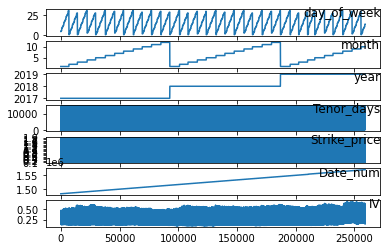

In [107]:
Plot_to_comp(df_n)

In [108]:
df_n.to_csv('IVS_Cleaned_Data.csv')

In [109]:
dataset = read_csv('IVS_Cleaned_Data.csv', header=0, index_col=0)
dataset

,day_of_week,month,year,Tenor_days,Strike_price,Date_num,IV
0,5,1,2017,59,0.1,1483574.4,0.5
1,5,1,2017,59,0.2,1483574.4,0.4
2,5,1,2017,59,0.3,1483574.4,0.4
3,5,1,2017,59,0.4,1483574.4,0.3
4,5,1,2017,59,0.5,1483574.4,0.3
...,...,...,...,...,...,...,...
259193,14,10,2019,14610,1.5,1571011.2,0.2
259194,14,10,2019,14610,1.6,1571011.2,0.2
259195,14,10,2019,14610,1.7,1571011.2,0.2
259196,14,10,2019,14610,1.8,1571011.2,0.2


In [110]:
def spliter(df):

  train_main_df, test_df = train_test_split(df, test_size=0.2,shuffle=False)
  train_df, val_df = train_test_split(train_main_df, test_size=0.2,shuffle=False)

  train=train_df.values
  Val=val_df.values
  test=test_df.values

  train_X, train_y = train[:, :-1], train[:, -1]
  Val_X, Val_y = Val[:, :-1], Val[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  Val_X = Val_X.reshape((Val_X.shape[0], 1, Val_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  print(train_X.shape, train_y.shape, Val_X.shape, Val_y.shape, test_X.shape, test_y.shape)

  return train_df,val_df,test_df,train_X,train_y,Val_X,Val_y,test_X,test_y

In [111]:
train_df,val_df,test_df,train_X,train_y,Val_X,Val_y,test_X,test_y=spliter(dataset)

(165886, 1, 6) (165886,) (41472, 1, 6) (41472,) (51840, 1, 6) (51840,)


In [118]:
def create_model(df):

  model = tf.keras.Sequential([
  layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=(df.shape[1], df.shape[2])),
  layers.LSTM(256,return_sequences=True),
  layers.Dense(128, activation='relu'),
  layers.LSTM(124,activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.003)),
  layers.Dense(64),
  layers.Dropout(0.25),
  layers.Dense(1),
  ])

  model.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(learning_rate=0.03,beta_1=0.9))

  return model

In [119]:
model_fin=create_model(train_X)

In [120]:
model_fin.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 1, 32)             608       
                                                                 
 lstm_44 (LSTM)              (None, 1, 256)            295936    
                                                                 
 dense_110 (Dense)           (None, 1, 128)            32896     
                                                                 
 lstm_45 (LSTM)              (None, 124)               125488    
                                                                 
 dense_111 (Dense)           (None, 64)                8000      
                                                                 
 dropout_65 (Dropout)        (None, 64)                0         
                                                                 
 dense_112 (Dense)           (None, 128)             

In [121]:
hist = model_fin.fit(train_X, train_y, epochs=99, batch_size=100, validation_data=(Val_X, Val_y), verbose=1, shuffle=False)

Epoch 1/99
1659/1659 [==============================] - 25s 13ms/step - loss: 0.9007 - val_loss: 0.1762
Epoch 2/99
1659/1659 [==============================] - 21s 12ms/step - loss: 0.1071 - val_loss: 0.0802
Epoch 3/99
1659/1659 [==============================] - 21s 12ms/step - loss: 0.0768 - val_loss: 0.0737
Epoch 4/99
1659/1659 [==============================] - 21s 12ms/step - loss: 0.0791 - val_loss: 0.0826
Epoch 5/99
1659/1659 [==============================] - 21s 13ms/step - loss: 0.0826 - val_loss: 0.0875
Epoch 6/99
1659/1659 [==============================] - 21s 12ms/step - loss: 0.0866 - val_loss: 0.0906
Epoch 7/99
1659/1659 [==============================] - 21s 12ms/step - loss: 0.0906 - val_loss: 0.0919
Epoch 8/99
1659/1659 [==============================] - 21s 13ms/step - loss: 0.0938 - val_loss: 0.0948
Epoch 9/99
1659/1659 [==============================] - 21s 13ms/step - loss: 0.0956 - val_loss: 0.0976
Epoch 10/99
1659/1659 [==============================] - 21s 13m

In [122]:
def loss_plot(his):
  pyplot.plot(his.history['loss'], label='train')
  pyplot.plot(his.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

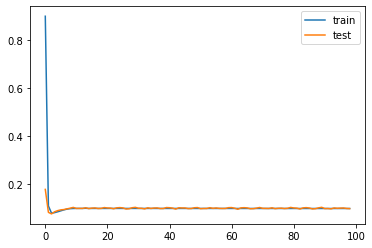

In [123]:
loss_plot(hist)

In [124]:
model_fin.save('./IVS_tf',save_format='tf')
!zip -r IVS_HACK.zip {'./IVS_tf'}

INFO:tensorflow:Assets written to: ./IVS_tf/assets


INFO:tensorflow:Assets written to: ./IVS_tf/assets


  adding: IVS_tf/ (stored 0%)
  adding: IVS_tf/saved_model.pb (deflated 90%)
  adding: IVS_tf/variables/ (stored 0%)
  adding: IVS_tf/variables/variables.data-00000-of-00001 (deflated 69%)
  adding: IVS_tf/variables/variables.index (deflated 70%)
  adding: IVS_tf/assets/ (stored 0%)
  adding: IVS_tf/keras_metadata.pb (deflated 92%)


In [125]:
!unzip /content/IVS_HACK.zip -d /content/
model_fin = tf.keras.models.load_model('./IVS_tf')

Archive:  /content/IVS_HACK.zip
replace /content/IVS_tf/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/IVS_tf/saved_model.pb  
replace /content/IVS_tf/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/IVS_tf/variables/variables.data-00000-of-00001  
replace /content/IVS_tf/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/IVS_tf/variables/variables.index  
replace /content/IVS_tf/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/IVS_tf/keras_metadata.pb  


In [126]:
yhat = model_fin.predict(test_X)

In [127]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y = inv_y[:,0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.086


In [128]:
x = concatenate((yhat, test_X[:, 4:5]), axis=1)
x=DataFrame(x)
x=x.iloc[:,::-1]
recovered_df = x.pivot_table(index = ind.Deadline_count, columns = 1,values = 0)
recovered_df.columns.name = None  
recovered_df.index.name=None
recovered_df

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
1,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
3,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
4,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2724,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2725,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2726,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2727,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2


In [129]:
df1=pd.read_csv('/content/drive/MyDrive/Problem_Statement/data/training_data.csv',sep=",")


In [130]:
a,b=train_test_split(df1,test_size=0.2,shuffle=False)
b=b.reset_index(drop=True)
final=pd.concat([b['Date'],b['Tenor'],recovered_df],axis=1)
final=final.fillna(0)
final.to_csv('prediction_template.csv')

In [131]:
predict= read_csv('prediction_template.csv', header=0, index_col=0)
predict

,Date,Tenor,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
0,3/20/2019,4Y,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
1,3/20/2019,5Y,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2,3/20/2019,6Y,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
3,3/20/2019,7Y,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
4,3/20/2019,8Y,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2724,10/14/2019,15Y,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2725,10/14/2019,20Y,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2726,10/14/2019,25Y,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
2727,10/14/2019,30Y,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
